# Object Recognition

In [2]:
import os.path
import time

from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline


import cv2
import numpy as np
import matplotlib.pyplot as plt

import feature_extraction
import utils

In [ ]:

points = img = train_set[0][0]
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img,None)

points = cv2.drawKeypoints(img, keypoints, points, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(points) 
plt.show()  # display it
print(str(len(descriptors)) + "x" + str(len(descriptors[0])))

In [ ]:
print(descriptors[0])
descs = descriptors[0]
for descriptor in descriptors[1:]:
    descs = np.vstack((descs, descriptor))

print(descs.shape)

## SIFT

In [43]:
classes = ['cactus', 'raccoon']
images = utils.load_images(classes)

Loaded 196 images of the classes: cactus, raccoon


In [44]:
print(images[0])

('cactus', array([[141, 151, 157, ..., 100, 120, 132],
       [156, 160, 163, ...,  92, 110, 123],
       [177, 175, 176, ...,  85, 100, 114],
       ...,
       [135, 132, 106, ...,  63, 160, 210],
       [139, 136, 121, ..., 124, 197, 210],
       [145, 140, 135, ..., 191, 193, 189]], dtype=uint8))


In [47]:
descriptors = []
sift = cv2.SIFT_create()

for classid, img in images:
    key, desc = sift.detectAndCompute(img,None)
    descriptors.append((classid, desc))

print(len(descriptors))

196


In [53]:
print(len(descriptors[1][1]))

2019


In [48]:
descs = descriptors[0][1]

for classid, desc in descriptors[1:]:
    descs = np.vstack((descs, desc))

print(descs.shape)

(262805, 128)


In [ ]:
k = len(classes) * 10
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=6)
kmeans.fit(descs)

print(len(kmeans.cluster_centers_))

In [ ]:
histo_all = []
nkp = np.size(kp)
print("nkp", nkp)

for classid, desc in descriptors:
    histo = np.zeros(k)
    
    for d in desc:
        idx = kmeans.predict([d])
        # instead of increasing each bin by one, add the normalized value
        histo[idx] += 1/nkp

    histo_all.append(histo)

In [ ]:
# HERE!! do we need 'standardscaler', StandardScaler() ?
# or PCA?
# how does the histograms look like? print them..

In [ ]:
nbins = len(histo_all[i])
for i in range(5):
    fig, ax = plt.subplots(tight_layout=True)
    hist = ax.hist(histo_all[i], bins=nbins)

In [ ]:
print(len(histo_all[0]))

In [ ]:
X = np.array(histo_all)
Y = []

# encode classes
classes = ['cactus', 'dice', 'raccoon', 'spaghetti', 'sushi']
for classid, desc in descriptors:
    val = 0
    if classid == 'cactus':
        val = 0
    if classid == 'dice':
        val = 1
    if classid == 'raccoon':
        val = 2
    if classid == 'spaghetti':
        val = 3
    if classid == 'sushi':
        val = 4
    
    Y.append(val)

In [ ]:
svm = LinearSVC()
svm.fit(X, Y)


In [ ]:
def getHistogram(img, cluster):
    # get features
    sift = cv2.SIFT_create()
    key, desc = sift.detectAndCompute(img,None)

    # create histogram
    histo = np.zeros(k)
    nkp = np.size(key)
    for d in desc:
        idx = cluster.predict([d])
        # instead of increasing each bin by one, add the normalized value
        histo[idx] += 1/nkp
        
    return histo

In [ ]:
print(test_set[0])

for i in range(5):
    hist = getHistogram(test_set[i][0], kmeans)
        
    classid = svm.predict([hist])
    print(test_set[i][1], classid)

In [ ]:
class SiftFeatures:
    def __init__(self, cluster_k):
        self.sift = cv2.SIFT_create()
        self.k = cluster_k
        self.cluster = MiniBatchKMeans(n_clusters=cluster_k, random_state=0, batch_size=6)
        self.features = []

    def fit(self, images):
        """
        Compute SIFT descriptors and learn clusters from data.
        :param images: list of tuple (classid, image)
        :return: list of tupple (classid, sift-descriptors)
        """
        
        print("Identifying descriptors..")
        descriptors = []
        for classid, img in images:
            key, desc = self.sift.detectAndCompute(img, None)
            descriptors.append((classid, desc))
            
        descs = descriptors[0][1]

        for classid, desc in descriptors[1:]:
            descs = np.vstack((descs, desc))
        
        print("Clustering data..")
        self.cluster.fit(descs)
        
        print("Clustered " + str(len(self.cluster.cluster_centers_)) + " centroids")
        
        return descriptors

    def get_histograms(self, descriptors):
        """
        Compute histogram of the given descriptors
        :param descriptors: list of tuple (classid, sift-descriptors) got from fit()
        :return: list of tupple (classid, histogram)
        """
        
        print("Calculating histograms for " + str(len(descriptors)) + " items.")
        histo_all = []
        for classid, desc in descriptors:
            histo = np.zeros(self.k)
            nkp = np.size(len(desc))

            for d in desc:
                idx = self.cluster.predict([d])
                # instead of increasing each bin by one, add the normalized value
                histo[idx] += 1/nkp

            histo_all.append((classid, histo))
        
        return histo_all
    
    def get_histograms_img(self, images):
        histo_all = []

        for classid, img in images:
            key, desc = self.sift.detectAndCompute(img, None)            
            histo = np.zeros(self.k)
            nkp = np.size(len(desc))

            for d in desc:
                idx = self.cluster.predict([d])
                # instead of increasing each bin by one, add the normalized value
                histo[idx] += 1/nkp

            histo_all.append((classid, histo))
        
        return histo_all

        

In [ ]:
classes = ['cactus', 'raccoon']
k = 100

images = utils.load_images(classes)
X, Y = utils.separate_data(images)
print(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

s = SiftFeatures(k)
descriptors = s.fit(zip(y_train, X_train))
histograms = s.get_histograms(descriptors)

X_h = [h[1] for h in histograms]
print("Training with " + str(len(X_h)) + " samples")

# train svm
svm = LinearSVC()
svm.fit(X_h, y_train)

test_histograms = s.get_histograms_img(zip(y_test, X_test))
X_test_h = [h[1] for h in test_histograms]
svm.score(X_test_h, y_test)

In [ ]:
predictions = svm.predict(X_test_h)
print(classification_report(y_test, predictions))

### Custom SkLearn transformer

In [30]:
class SiftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_k=100):
        # super(SiftTransformer, self).__init__()
        self.sift = cv2.SIFT_create()
        self.cluster_k = cluster_k
        print("using K: " + str(self.cluster_k))
        self.cluster = MiniBatchKMeans(n_clusters=cluster_k, random_state=0, batch_size=6)
        self.features = []

    def fit(self, X, y=None, **kwargs):
        """
        Compute SIFT descriptors and learn clusters from data.
        :param X: features
        :param y: target vector
        :return: self: the class object
        """
        
        print("Identifying descriptors..")
        descriptors = []
        for img in X:
            key, desc = self.sift.detectAndCompute(img, None)
            descriptors.append(desc)
            
        descs = descriptors[0]

        for desc in descriptors[1:]:
            descs = np.vstack((descs, desc))
        
        print("descriptors shape: " + str(descs.shape))
        print("Clustering data..")
        self.cluster.fit(descs)
        
        print("Clustered " + str(len(self.cluster.cluster_centers_)) + " centroids")
        
        return self

    def transform(self, X, y=None, **kwargs):
        """
        Compute histogram of X
        :param X: features
        :return: list of tupple histogram
        """
        
        print("Calculating histograms for " + str(len(X)) + " items.")
        histo_all = []
        for img in X:
            key, desc = self.sift.detectAndCompute(img, None)
            
            histo = np.zeros(self.cluster_k)
            nkp = np.size(len(key))

            for d in desc:
                idx = self.cluster.predict([d])
                # instead of increasing each bin by one, add the normalized value
                histo[idx] += 1/nkp

            histo_all.append(histo)
        
        return histo_all
    
    def fit_transform(self, X, y=None, **kwargs):
        print("fit and transforming..")
        
        self = self.fit(X, y)
        return self.transform(X, y)
    
    def get_histograms(self, images):
        """
        Calculate histograms for given images
        :param images: list of images
        :return: list of histograms
        """
        histo_all = []

        for img in images:
            key, desc = self.sift.detectAndCompute(img, None)            
            histo = np.zeros(self.cluster_k)
            nkp = np.size(len(desc))

            for d in desc:
                idx = self.cluster.predict([d])
                # instead of increasing each bin by one, add the normalized value
                histo[idx] += 1/nkp

            histo_all.append(histo)
        
        return histo_all

        

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

classes = ['cactus', 'dice', 'raccoon', 'spaghetti', 'sushi']
k = 128

images = utils.load_images(classes)
X, Y = utils.separate_data(images)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

pipeline = Pipeline([
    ('sift', SiftTransformer(k)),
    ('std', StandardScaler()),
    # ('svm', SVC(probability=True))
    ('svm', LinearSVC())
])

print("Training with " + str(len(X_train)) + " samples")
pipeline.fit(X_train, y_train)


Loaded 490 images of the classes: cactus, dice, raccoon, spaghetti, sushi
using K: 100
Training with 294 samples
fit and transforming..
Identifying descriptors..
descriptors shape: (297510, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=100. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=100. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=100. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 100 centroids
Calculating histograms for 294 items.


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(memory=None,
         steps=[('sift', SiftTransformer(cluster_k=100)),
                ('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [41]:
pipeline.score(X_test, y_test)
# 0.734

# SVC: 0.6071428571428571 (all classes)
# LinearSVC: 0.8860759493670886 (2 classes)
# LinearSVC: 0.49489795918367346 (all classes)

Calculating histograms for 196 items.


0.49489795918367346

In [39]:
from sklearn.metrics import confusion_matrix
predictions = pipeline.predict(X_test)
confusion_matrix(y_test, predictions)

Calculating histograms for 79 items.


KeyboardInterrupt: 

[0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2]
[2 0 2 2 2 2 0 2 0 2 2 0 2 2 2 0 2 2 0 2 0 2 2 0 0 0 2 2 2 2 2 2 0 0 2 0 2
 2 2 0 2 2 2 0 0 0 2 0 2 2 0 0 0 2 2 2 2 0 0 2 2 0 2 2 0 0 2 2 0 0 0 2 2 2
 0 2 2 0 2]
[[0.30379747 0.17721519]
 [0.08860759 0.43037975]]


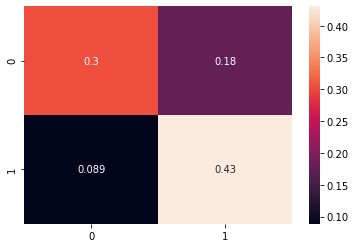

In [13]:
import seaborn as sn
from sklearn.metrics import f1_score

print(y_test)
print(predictions)

# print(f1_score(y_test, predictions))
conf = confusion_matrix(y_test, predictions)
print(conf/79)
sn.heatmap(conf/79, annot=True)


In [54]:
from sklearn.model_selection import GridSearchCV

classes = ['cactus', 'dice', 'raccoon', 'spaghetti', 'sushi']
k = 128 * 3

images = utils.load_images(classes)
X, Y = utils.separate_data(images)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

pipeline = Pipeline([
    ('sift', SiftTransformer()),
    ('std', StandardScaler()),
    ('svm',LinearSVC())
])

parameters = {'svm__C':[1, 10, 100, 1000], 'sift_k': [100, 400, 50]}
grid = GridSearchCV(pipeline, parameters)
grid.fit(X_train, y_train)


Loaded 490 images of the classes: cactus, dice, raccoon, spaghetti, sushi
using K: 384
using K: 384
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (231010, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (234315, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (238772, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (241575, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (244368, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 236 items.
Calculating histograms for 58 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (231010, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (234315, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (238772, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (241575, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (244368, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 236 items.
Calculating histograms for 58 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (231010, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (234315, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (238772, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (241575, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (244368, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 236 items.
Calculating histograms for 58 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (231010, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (234315, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (238772, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (241575, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 235 items.
Calculating histograms for 59 items.
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (244368, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 236 items.
Calculating histograms for 58 items.
using K: 384
using K: 384
fit and transforming..
Identifying descriptors..
descriptors shape: (297510, 128)
Clustering data..


/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=384. Setting it to 3*k
  cluster_centers = _init_centroids(


Clustered 384 centroids
Calculating histograms for 294 items.


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sift', SiftTransformer(cluster_k=384)),
                                       ('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                  

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid.cv_results_, parameters['svm__C'], max_features, 'N Estimators', 'Max Features')


In [56]:
grid.cv_results_

{'mean_fit_time': array([532.51456909, 490.39444189, 429.10783982, 495.8562983 ]),
 'std_fit_time': array([109.71378459, 115.00148765,  86.23317645, 162.72420607]),
 'mean_score_time': array([63.71216307, 52.99047041, 51.83683667, 60.75148864]),
 'std_score_time': array([12.04804738,  6.31344059,  5.53529896, 12.62813601]),
 'param_svm__C': masked_array(data=[1, 10, 100, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svm__C': 1}, {'svm__C': 10}, {'svm__C': 100}, {'svm__C': 1000}],
 'split0_test_score': array([0.42372881, 0.42372881, 0.42372881, 0.42372881]),
 'split1_test_score': array([0.66101695, 0.66101695, 0.66101695, 0.66101695]),
 'split2_test_score': array([0.61016949, 0.61016949, 0.61016949, 0.61016949]),
 'split3_test_score': array([0.57627119, 0.57627119, 0.57627119, 0.57627119]),
 'split4_test_score': array([0.5, 0.5, 0.5, 0.5]),
 'mean_test_score': array([0.55423729, 0.55423729, 0.55423729, 0.5542372